Starting analysis pipeline...
1. Downloading street network...
2. Downloading amenities...
3. Cleaning data...
4. Projecting and extracting centroids...
Data ready: 51 temples, 28 shelters
5. Calculating network coverage...

=== Results ===
Base Coverage (Shelters):   19.4%
Enhanced Coverage (+Temples): 24.6%
Improvement:                +5.2%
6. Generating map...


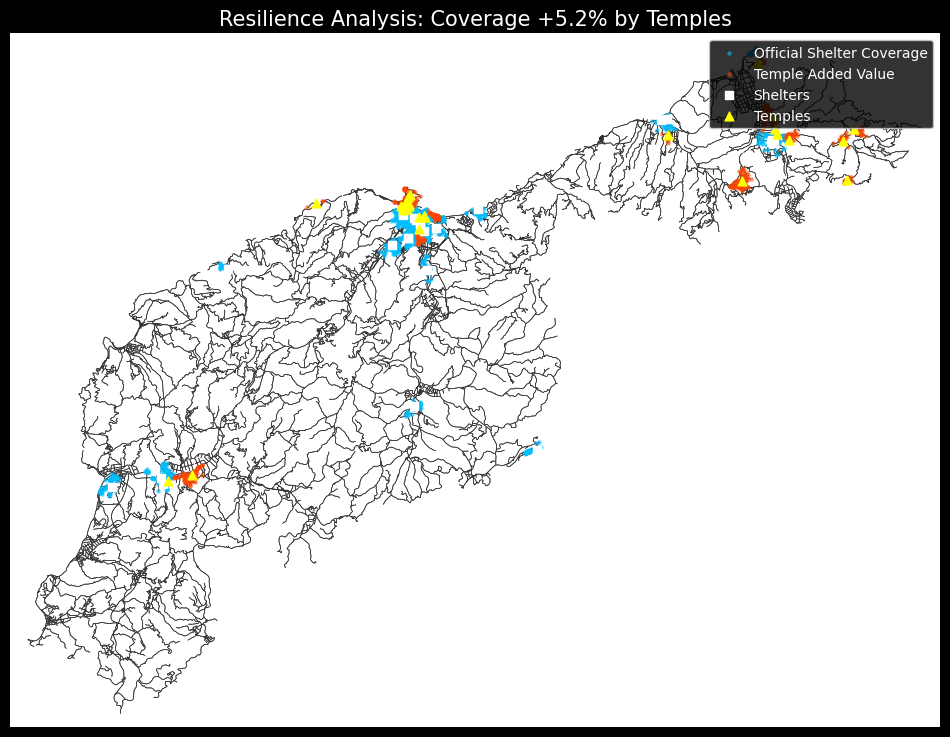

In [12]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

print("Starting analysis pipeline...")

# ==========================================
# Step 1: Data Acquisition
# ==========================================
place_name = "Wajima, Ishikawa, Japan"
print("1. Downloading street network...")
G = ox.graph_from_place(place_name, network_type='walk')

print("2. Downloading amenities...")
tags_temple = {'amenity': 'place_of_worship', 'religion': 'buddhist'}
temples = ox.features_from_place(place_name, tags=tags_temple)

tags_shelter = {'amenity': ['school', 'community_centre']}
shelters = ox.features_from_place(place_name, tags=tags_shelter)

# ==========================================
# Step 2: Data Cleaning
# ==========================================
print("3. Cleaning data...")

def clean_gdf(gdf):
    # Remove rows without geometry and empty geometries
    gdf = gdf[gdf.geometry.notna()]
    gdf = gdf[~gdf.geometry.is_empty]
    return gdf

temples = clean_gdf(temples)
shelters = clean_gdf(shelters)

# ==========================================
# Step 3: Projection & Standardization
# ==========================================
print("4. Projecting and extracting centroids...")

# Project graph to local UTM
G_proj = ox.project_graph(G)
target_crs = G_proj.graph['crs']

# Project features to match graph CRS
temples = temples.to_crs(target_crs)
shelters = shelters.to_crs(target_crs)

# Convert polygons to centroids
temples['geometry'] = temples.geometry.centroid
shelters['geometry'] = shelters.geometry.centroid

# Final validity check after projection
temples = temples[temples.geometry.notna() & ~temples.geometry.x.isna()]
shelters = shelters[shelters.geometry.notna() & ~shelters.geometry.x.isna()]

print(f"Data ready: {len(temples)} temples, {len(shelters)} shelters")

# ==========================================
# Step 4: Coverage Analysis (15-min walk)
# ==========================================
print("5. Calculating network coverage...")

# Find nearest network nodes
shelter_nodes = ox.distance.nearest_nodes(G_proj, X=shelters.geometry.x, Y=shelters.geometry.y)
temple_nodes = ox.distance.nearest_nodes(G_proj, X=temples.geometry.x, Y=temples.geometry.y)

def get_reachable_nodes(graph, start_nodes, distance_meters):
    """Return set of nodes reachable within distance_meters from start_nodes."""
    reachable_nodes = set()
    for start_node in start_nodes:
        subgraph = nx.ego_graph(graph, start_node, radius=distance_meters, distance='length')
        reachable_nodes.update(subgraph.nodes())
    return reachable_nodes

# Calculate coverage sets (720m approx 15 mins)
coverage_shelters = get_reachable_nodes(G_proj, shelter_nodes, distance_meters=720)
coverage_temples = get_reachable_nodes(G_proj, temple_nodes, distance_meters=720)
coverage_all = coverage_shelters.union(coverage_temples)

# Calculate metrics
total_nodes = len(G_proj.nodes())
base_pct = len(coverage_shelters) / total_nodes * 100
final_pct = len(coverage_all) / total_nodes * 100
improvement = final_pct - base_pct

print(f"\n=== Results ===")
print(f"Base Coverage (Shelters):   {base_pct:.1f}%")
print(f"Enhanced Coverage (+Temples): {final_pct:.1f}%")
print(f"Improvement:                +{improvement:.1f}%")

# ==========================================
# Step 5: Visualization
# ==========================================
print("6. Generating map...")
fig, ax = plt.subplots(figsize=(12, 12), facecolor='black')

# Plot background network
ox.plot_graph(G_proj, ax=ax, node_size=0, edge_color='#333333',
              edge_linewidth=0.5, show=False, close=False, bgcolor='black')

# Plot official coverage (Blue)
if len(coverage_shelters) > 0:
    x_s = [G_proj.nodes[n]['x'] for n in coverage_shelters]
    y_s = [G_proj.nodes[n]['y'] for n in coverage_shelters]
    ax.scatter(x_s, y_s, c='#00BFFF', s=10, alpha=0.6, linewidths=0,
               label='Official Shelter Coverage', zorder=2)

# Plot added value by temples (Red)
added_nodes = coverage_temples - coverage_shelters
if len(added_nodes) > 0:
    x_t = [G_proj.nodes[n]['x'] for n in added_nodes]
    y_t = [G_proj.nodes[n]['y'] for n in added_nodes]
    ax.scatter(x_t, y_t, c='#FF4500', s=10, alpha=0.6, linewidths=0,
               label='Temple Added Value', zorder=3)

# Plot facility locations
ax.scatter(shelters.geometry.x, shelters.geometry.y, c='white', marker='s', s=40, label='Shelters', zorder=5)
ax.scatter(temples.geometry.x, temples.geometry.y, c='yellow', marker='^', s=40, label='Temples', zorder=5)

ax.set_title(f"Resilience Analysis: Coverage +{improvement:.1f}% by Temples", fontsize=15, color='white')
ax.legend(loc='upper right', facecolor='black', labelcolor='white')
plt.savefig("wajima_resilience_analysis.png", dpi=300, bbox_inches='tight')
plt.show()